## Sample Overview

Here, we select the first 100 of 2252 scaped photographs. The ChatGPT integration is the final cell.

In [1]:
import io
import cv2
import json
import time
import requests
import numpy as np
from matplotlib import pyplot as plt
from random import sample as samp
from IPython.display import clear_output
from lib.util import to_ai_url, setup_plt
from lib.load import index_urls, gen_images
from lib.load import index_classes
from lib.util import setup_viz_box, draw_viz_box
from lib.truth import to_truth
from lib.ai import gen_results
from lib.stats import to_ious

USE_AWS_AI = True

print("testing", "on aws" if (USE_AWS_AI) else "locally")
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams["figure.dpi"] = 40

NUM_READ = 100
photos = []

classes = list(index_classes('images.json'))
photo_sources = []
with open('images.json', 'r') as rf:
    for f in json.load(rf)[1:]:
        if (len(photo_sources) >= NUM_READ): break
        photo_sources.append({"file_name": f})

print(f'Loading {len(photo_sources)} photos...')
photo_gen = gen_images(photo_sources, '/')

for photo in photo_gen:
    photos.append(photo)
    if len(photos) % 10 == 0:
        clear_output(wait=True)
        print(round(100*len(photos)/len(photo_sources)),'%')

print('Loaded', len(photos), 'images!')

## OCR

100 %
Loaded 100 images!


In [2]:
try: photos
except NameError:
    raise(Exception("Please run prior cell"))
try: USE_AWS_AI
except NameError:
    raise(Exception("Please run first cell"))

results = []
for res in gen_results(USE_AWS_AI, photos):
    results.append(res)
    clear_output(wait=True)
    print(round(100*len(results)/len(photo)),'%')

6 %
Done with classifier and OCR!


In [3]:
from pathlib import Path

try: photo_sources and results
except NameError:
    raise(Exception("Please run prior cells"))

def list_classes(photo_sources):
    classes = []
    for s in photo_sources:
        cls = Path(s["file_name"]).parent.name
        classes.append({ "text": cls })
    return classes

truth = list_classes(photo_sources)
samples = list(zip(truth, results))
print(f'sample size: {len(samples)}')

sample size: 100


# Evaluation

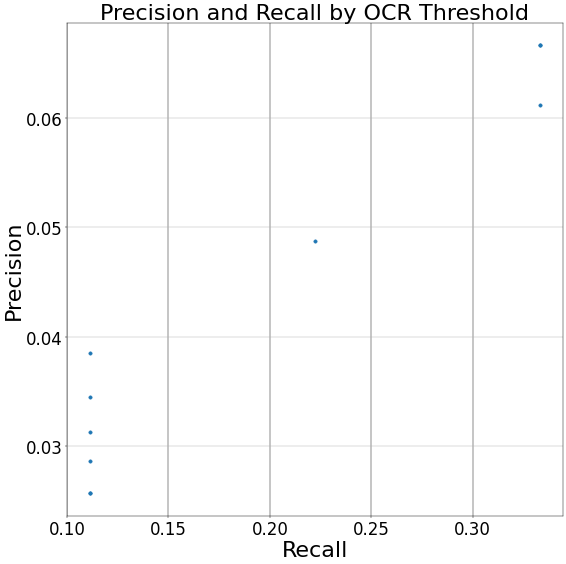

In [4]:
from Levenshtein import distance

try: truth and results
except NameError:
    raise(Exception("Please run prior cells"))

def sort_by_confidence(res):
    if len(res["ocr_all_results"]) == 0:
        return {**res}
    ocr_confident = sorted(res["ocr_all_results"], key=lambda r: ["score"], reverse=True)
    return {**res, "ocr_all_results": [ocr_confident[0]]}
    
f_r = [sort_by_confidence(r) for r in results]

def filter_by_confidence(rea, res, thresh):
    if len(res["ocr_all_results"]) == 0: return False
    return res["ocr_all_results"][0]["score"] > thresh

def filter_by_dist(rea, res):
    if (len(res["ocr_all_results"]) == 0): return False
    lev = distance(rea["text"], res["prediction"])
    # Levenshtein distance
    return lev <= 3

ALL_THRESH = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
ALL_PRECISION = []
ALL_RECALL = []

# Calculate precision and recall
for THRESH in ALL_THRESH:
    retrieved = [v for v in zip(truth, f_r) if filter_by_confidence(v[0], v[1], THRESH)]
    relevant = [v for v in zip(truth, f_r) if filter_by_dist(v[0], v[1])]
    relevant_retrieved = [v for v in retrieved if filter_by_dist(v[0], v[1])]
    ALL_PRECISION.append(len(relevant_retrieved)/len(retrieved))
    ALL_RECALL.append(len(relevant_retrieved)/len(relevant))

# Data from presentation
#ALL_PRECISION = [0.0625, 0.06818181818181818, 0.06818181818181818, 0.05, 0.02631578947368421, 0.02631578947368421, 0.029411764705882353, 0.03225806451612903, 0.03571428571428571, 0.04]
#AL__RECALL = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.2222222222222222, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]

plt.gca().xaxis.grid(True, color='k')
plt.gca().yaxis.grid(True)
plt.scatter(ALL_RECALL, ALL_PRECISION)
plt.title(f'Precision and Recall by OCR Threshold', fontsize = 40)
plt.tick_params(axis='both', which='major', labelsize = 30)

plt.xlabel("Recall", fontsize=40)
plt.ylabel("Precision", fontsize=40)
plt.show() # TODO